In [1]:
import pandas as pd
import numpy as np
import gensim
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, SimpleRNN, Dense,Flatten,Dropout,GRU
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score,classification_report
import gensim.downloader as api
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
import matplotlib.pyplot as plt

import tensorflow as tf
import random
seed = 42
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

# Read preprocessed data

In [2]:
df = pd.read_csv("../dataset_imdb_preprocessed.csv",index_col=0)
df

,sentiment,lemmatized_review
0,1,one reviewer ha mentioned watching 1 oz episod...
1,1,wonderful little production filming technique ...
2,1,thought wa wonderful way spend time hot summer...
3,0,basically family little boy jake think zombie ...
4,1,petter mattei love time money visually stunnin...
...,...,...
49995,1,thought movie right good job wa creative origi...
49996,0,bad plot bad dialogue bad acting idiotic direc...
49997,0,catholic taught parochial elementary school nu...
49998,0,going disagree previous comment side maltin on...


# Split

In [3]:
X_train, X_test, y_train, y_test = train_test_split(df['lemmatized_review'], df['sentiment'], test_size=0.2, random_state=seed)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.15, random_state=seed)

# Load model Work2Vec

In [4]:
w2v_model = api.load("word2vec-google-news-300")

# Create Embedding Matrix

In [5]:
tokenizer = Tokenizer(num_words=10000)
tokenizer.fit_on_texts(X_train)


X_train_seq = tokenizer.texts_to_sequences(X_train)
X_val_seq = tokenizer.texts_to_sequences(X_val)
X_test_seq = tokenizer.texts_to_sequences(X_test)


max_length = 100
X_train_seq = pad_sequences(X_train_seq, maxlen=max_length)
X_val_seq = pad_sequences(X_val_seq, maxlen=max_length)
X_test_seq = pad_sequences(X_test_seq, maxlen=max_length)


embedding_dim = 300
embedding_matrix = np.zeros((len(tokenizer.word_index) + 1, embedding_dim))

for word, i in tokenizer.word_index.items():
    if word in w2v_model:
        embedding_matrix[i] = w2v_model[word]


embedding_layer = Embedding(input_dim=len(tokenizer.word_index) + 1,
                            output_dim=embedding_dim,
                            weights=[embedding_matrix],
                            input_length=max_length,
                            trainable=False)

# Model

In [6]:

#####################81%
model = Sequential()
model.add(embedding_layer)
model.add(Flatten()) 
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5)) 
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5)) 
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5)) 
model.add(Dense(1, activation='sigmoid'))

model.summary()
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])





early_stopping = EarlyStopping(monitor='val_loss',patience=5,restore_best_weights=True)  
model.fit(X_train_seq, y_train, epochs=10, batch_size=32,validation_data=(X_val_seq, y_val),callbacks=[early_stopping])


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 300)          23351400  
                                                                 
 flatten (Flatten)           (None, 30000)             0         
                                                                 
 dense (Dense)               (None, 512)               15360512  
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 256)               131328    
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_2 (Dense)             (None, 128)               3

# evaluate

In [7]:
predictions = model.predict(X_test_seq)
y_pred = (predictions > 0.5).astype(int)


precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)

print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")
print(f"Accuracy: {accuracy:.2f}")

print(classification_report(y_test, y_pred))



313/313 [==============================] - 0s 780us/step
Precision: 0.78
Recall: 0.86
F1 Score: 0.82
Accuracy: 0.81
              precision    recall  f1-score   support

           0       0.84      0.75      0.79      4961
           1       0.78      0.86      0.82      5039

    accuracy                           0.81     10000
   macro avg       0.81      0.81      0.81     10000
weighted avg       0.81      0.81      0.81     10000



'\nMLP 10 epochs 81%\nGRU 10 epochs 87%\nGRU 8 epochs by early stopping 88% with 1 or 2 GRU layers\n'

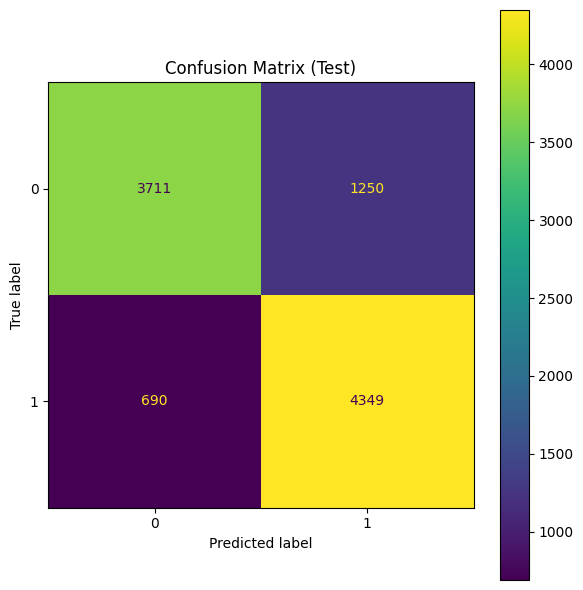

In [8]:
cm_test = confusion_matrix(y_test, y_pred)

fig, ax = plt.subplots(figsize=(6, 6))  

ConfusionMatrixDisplay(cm_test).plot(ax=ax, colorbar=True)
ax.set_title('Confusion Matrix (Test)')

plt.tight_layout()
plt.show()
